# ELE 435/535 Lab 6

### Due Date : 11/11 Mon 11:59 PM

Francisco Carrillo

In [1]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

%matplotlib inline

### Load MNIST Dataset 

We will be working with the subset of MNIST that was used for HW1 in this HW. The training data contains 10,000 samples of different digits. Let's call it matrix D (of dimension 784 * 10000). The first 1000 columns of D correspond to digit 0 ($D_0$), the next 1000 correspond to digit 1 ($D_1$), etc. 

In [2]:
train_data = np.load('MNISTcwtrain1000.npy')
train_data = train_data.astype(dtype='float64')
test_data = np.load('MNISTcwtest100.npy')
test_data = test_data.astype(dtype='float64')

train_data = train_data/255.0
test_data = test_data/255.0

### Q1) Collaborative Representation Based Classification Using Lasso

In a previous HW, we used least squares regression for classifiying data. Given any new example (x), we would like to represent it as a linear combination of columns of D (hence, the name representation based classification). This can be acheived by finding a vector w (of dimension 1,000) that satisfies: $w = \arg\min \hspace{1mm} \|Dw - x \|_2$.

The first 100 elements of w ($w_0$) quantify how much of each column from digit 0 are needed to represent x. Similarly, the next 100 elements ($w_1$) correspond to weights on $D_1$, etc.

Next, prediction of pixel values of any test image (x) based only on examples of a particual digit $i$ can be found using $y_i' = D_i \times w_i$. Then, k-th digit that yields the lowest mean squared prediction error (i.e., $k = \arg\min \hspace{1mm} \|y -y'_i \|_2$) will determine the label of x. 

Following this procedure to predict the labels of each test example, the testing accuracy is 0.76.

#### * Use reduced training set ($Xr$) and test set ($test$) defined below. This will save the running time.

In [3]:
Xr=np.zeros((784,1000))
test=np.zeros((784,100))
for ind in range(10):
    Xr[:,100*ind:100*(ind+1)] = train_data[:,1000*ind:1000*ind+100]
    test[:,10*ind:10*(ind+1)] = test_data[:,100*ind:100*ind+10]

In [4]:
# least square
X = np.matrix(Xr)
[U,sigma,V] = np.linalg.svd( X, full_matrices=False) #decompose X
index = np.where(sigma>1e-4) #Make lower rank
trunc = index[0][-1]
INV_Mat = np.linalg.pinv(np.dot(X.T,X)) 
Projection_Mat = INV_Mat * (X.T) 
predicted_label = np.zeros((100,))
for i in range(0,100):
    test_ex = np.matrix(test[:,i]).T 
    p = Projection_Mat * test_ex
    dist = np.zeros((10,))
    for j in range(0,10):
        sub_mat = X[:,j*100:(j+1)*100]
        sub_W = p[j*100:(j+1)*100] 
        reconstructed = np.dot(sub_mat, sub_W) #forming Y
        dist[j] = np.linalg.norm(reconstructed - test_ex)
    predicted_label[i] = np.argmin(dist)
true_label = np.zeros((100,))
for i in range(0,10):
    true_label[i*10:(i+1)*10] = i
test_err = np.count_nonzero(predicted_label - true_label)
test_acc = 1-(test_err/100.0)

print("Test Accuacy :::::: " + str(test_acc))

Test Accuacy :::::: 0.76


Now, instead of using least square, we use LASSO in this question to find a sparse $w$. The idea behind is that we only want to use a small number of training samples to represent the test sample. Then, the objective is to find a vector $w$ that satisfies: $w = \arg\min \hspace{2mm} \|Dw - x \|_2 ^2 + \lambda \|w \|_1$. 

In [5]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

# Lasso

def LassoFit(lam):
    true_label = np.zeros((100,))
    for i in range(0,10):
        true_label[i*10:(i+1)*10] = i
        
    predicted_label = np.zeros((100,))
    #wMaster = np.zeros((1000,100))
    nonZeroWs = np.zeros((1,100))
    nkMaster = np.zeros((1,100))
    classifier = Lasso(alpha=lam, max_iter=2000)

    for i in range(0,100):    
        classifier.fit(Xr, test[:,i])
        w = classifier.coef_
        nonZeroWs[:,i] = np.count_nonzero(w)
        nk= np.count_nonzero(w[int(true_label[i])*100:(int(true_label[i])+1)*100]) / (np.count_nonzero(w)+0.01)
        nkMaster[:,i] = nk
        #wMaster[:,i] = w
        dist = np.zeros((10,))
        for j in range(0,10):
            sub_mat = Xr[:,j*100:(j+1)*100]
            sub_W =w[j*100:(j+1)*100] 
            reconstructed = sub_mat @ sub_W 
            dist[j] = np.linalg.norm(reconstructed - test[:,i])
        predicted_label[i] = np.argmin(dist)

    test_err = np.count_nonzero(predicted_label - true_label)
    test_acc = 1-(test_err/100.0)
    avgNonZeroWs = nonZeroWs.mean()
    avgNK = nkMaster.mean()

    print("Test Accuacy :::::: " + str(test_acc))
    
    return test_acc, avgNonZeroWs, avgNK

1.Try $\lambda = 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1, 10, 100$ and plot testing accuracy vs. $\lambda$. Compare the testing accuracy with that from least square. 

You can use the Lasso solver in Scikit-learn (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). Note that the objective function of Lasso solver in Scikit-learn might be different from what we defined here. Please adjust your arguments to the solver accordingly.

In [6]:
##THIS TAKES A WHILE, SO I RAN IT, COMMENTED OUT AND, COPIED THE SOLUTIONS LATER ON

#lambdaList = [1e-5, 1e-4 ,1e-3, 1e-2, 1e-1, 1, 10, 100]

#acc=[]
#wAvgNonZero=[]
#avgNK = []

#for l in lambdaList:
#    acc1, wAvg1, avgNK1 = LassoFit(l)
#    acc.append(acc1)
#    wAvgNonZero.append(wAvg1)
#    avgNK.append(avgNK1)

#print(acc,wAvgNonZero,avgNK)

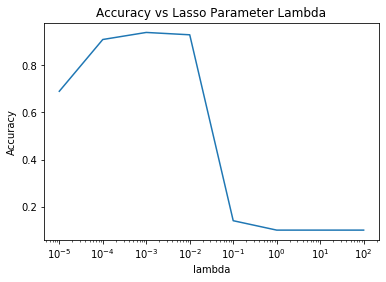

ANSWER:
The accuracy at the middle lambdas (~1e-3) improves when compared to least squares. The test acuracy worsens as we increase lambda. Furthermore, the decrease in accuracy at low lambdas has to do with the fact that the solver takes a very long time to reach the desired tolerance at low lambdas. If we increase the number of iterations until everything converges we would get a similar accuracy between lambda=1e-5 and lambda=0 (least squares). The graphed case refers to max-iter=2000


In [7]:
#Loading Solutions
lambdaList = [1e-5, 1e-4 ,1e-3, 1e-2, 1e-1, 1, 10, 100]
acc = [0.69, 0.91, 0.94, 0.9299999999999999, 0.14, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998]
wAvg = [581.4, 319.41, 107.59, 14.23, 0.12, 0.0, 0.0, 0.0]
avgNK = [0.11208197080340128, 0.1298344619835709, 0.19528901848290875, 0.524054843483635, 0.08428156248460666, 0.0, 0.0, 0.0]

#plotting
plt.semilogx(lambdaList,acc)
plt.title('Accuracy vs Lasso Parameter Lambda')
plt.ylabel("Accuracy")
plt.xlabel("lambda")
plt.show()

print("ANSWER:")
print('The accuracy at the middle lambdas (~1e-3) improves when compared to least squares. The test acuracy worsens as we increase lambda. Furthermore, the decrease in accuracy at low lambdas has to do with the fact that the solver takes a very long time to reach the desired tolerance at low lambdas. If we increase the number of iterations until everything converges we would get a similar accuracy between lambda=1e-5 and lambda=0 (least squares). The graphed case refers to max-iter=2000')

2.Plot the average number of nonzero entries in $w$ vs. $\lambda$.

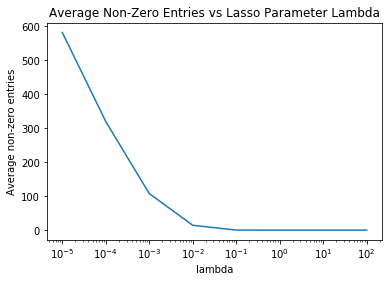

In [8]:
#plotting
plt.semilogx(lambdaList,wAvg)
plt.title('Average Non-Zero Entries vs Lasso Parameter Lambda')
plt.ylabel("Average non-zero entries")
plt.xlabel("lambda")
plt.show()

3.For each test sample, suppose $k$ is the right label, define $nk$ as nonzeros in $w_k$ / total # nonzeros in $w$. Plot the average of $nk$ over all testing samples vs. $\lambda$. What do you find?

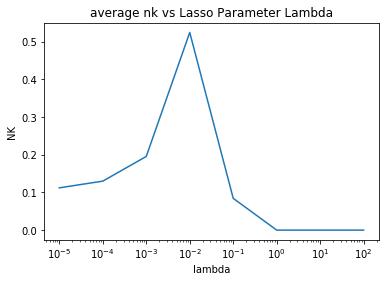

ANSWER:
We find that we get an optimum at a around lambda = 1e-2. This refers to the fact that we have a high enough penalization term to zero most of the values in w, but not high enough to 'filter out', the relevant term in w_k.


In [9]:
#plotting
plt.semilogx(lambdaList,avgNK)
plt.title('average nk vs Lasso Parameter Lambda')
plt.ylabel("NK")
plt.xlabel("lambda")
plt.show()

print("ANSWER:")
print("We find that we get an optimum at a around lambda = 1e-2. This refers to the fact that we have a high enough penalization term to zero most of the values in w, but not high enough to 'filter out', the relevant term in w_k.")

### Q2) Collaborative Representation Based Classification Using Elastic Net

We now use the elastic net objective function to find $w$: $w = \arg\min \hspace{2mm} \|Dw - x \|_2 ^2 + \lambda (\alpha \|w \|_1+0.5(1-\alpha) \|w \|_2 ^2 )$. It linearly combines the $L1$ and $L2$ penalties. Choose an appropriate $\lambda$ from Q1, and vary $\alpha$ in the range $(0,1)$.

You can use Scikit-learn ElasticNet (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html). Refer to the documentation on the web.

4.Plot testing accuracy vs. $\alpha$. Compare the testing accuracy with that from least square and Lasso. 

In [10]:
from sklearn.linear_model import ElasticNet

# Elastic Net

def NetFit(ratio):
    true_label = np.zeros((100,))
    for i in range(0,10):
        true_label[i*10:(i+1)*10] = i
        
    predicted_label = np.zeros((100,))
    nonZeroWs = np.zeros((1,100))
    nkMaster = np.zeros((1,100))
    classifier = ElasticNet(alpha=1e-3, l1_ratio = ratio, max_iter=2000)

    for i in range(0,100):    
        classifier.fit(Xr, test[:,i])
        w = classifier.coef_
        nk= np.count_nonzero(w[int(true_label[i])*100:(int(true_label[i])+1)*100]) / (np.count_nonzero(w)+0.01)
        nkMaster[:,i] = nk
        nonZeroWs[:,i] = np.count_nonzero(w)
        dist = np.zeros((10,))
        for j in range(0,10):
            sub_mat = Xr[:,j*100:(j+1)*100]
            sub_W =w[j*100:(j+1)*100] 
            reconstructed = sub_mat @ sub_W 
            dist[j] = np.linalg.norm(reconstructed - test[:,i])
        predicted_label[i] = np.argmin(dist)

    test_err = np.count_nonzero(predicted_label - true_label)
    test_acc = 1-(test_err/100.0)
    avgNonZeroWs = nonZeroWs.mean()
    avgNK = nkMaster.mean()

    print("Test Accuacy :::::: " + str(test_acc))
    
    return test_acc, avgNonZeroWs, avgNK

In [11]:
##THIS TAKES A WHILE, SO I RAN IT, COMMENTED OUT AND, COPIED THE SOLUTIONS LATER ON

#Ratios = [0, 0.2, 0.4, 0.6, 0.8, 1]

#accQ2=[]
#avgNonZeroWsQ2=[]
#avgNKQ2 = []

#for r in Ratios:
#    acc1, wAvg1, avgNK1 = NetFit(r)
#    accQ2.append(acc1)
#    avgNonZeroWsQ2.append(wAvg1)
#    avgNKQ2.append(avgNK1)

#print(accQ2,avgNonZeroWsQ2,avgNKQ2)

In [12]:
#Loading Results
Ratios = [0, 0.2, 0.4, 0.6, 0.8, 1]
accQ2 = [0.83, 0.92, 0.9299999999999999, 0.9299999999999999, 0.94, 0.94]
avgNonZeroWsQ2 = [1000.0, 285.17, 193.86, 151.66, 125.94, 107.59]
avgNKQ2 = [0.0999990000099999, 0.14049364819878374, 0.1605660644277942, 0.17355305715068428, 0.18564418607272984, 0.19528901848290875]

5.Plot the average number of nonzero entries in $w$ vs. $\alpha$ and average $nk$ vs. $\alpha$. What do you find?

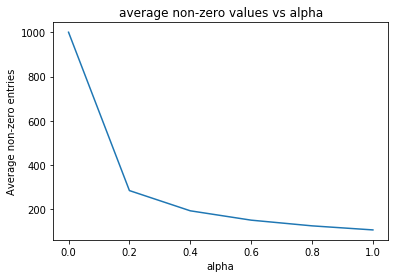

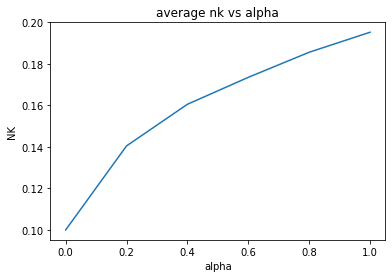

ANSWER:
These results make sense. As we decrease alpha to 0 we basically remove the lasso penalty, which is why the average non-zero entries increase towards the actual number of total values (1000), and NK goes to 10%, which is what the ratio should be for a 'w' that has no zero values. The oposite is true as we increase alpha to 1, where we recover the lasso behaviour shown in the previous question


In [13]:
#plotting  avg w vs alpha
plt.plot(Ratios,avgNonZeroWsQ2)
plt.title('average non-zero values vs alpha')
plt.ylabel("Average non-zero entries")
plt.xlabel("alpha")
plt.show()

#plotting NK vs alpha
plt.plot(Ratios,avgNKQ2)
plt.title('average nk vs alpha')
plt.ylabel("NK")
plt.xlabel("alpha")
plt.show()

print("ANSWER:")
print("These results make sense. As we decrease alpha to 0 we basically remove the lasso penalty, which is why the average non-zero entries increase towards the actual number of total values (1000), and NK goes to 10%, which is what the ratio should be for a 'w' that has no zero values. The oposite is true as we increase alpha to 1, where we recover the lasso behaviour shown in the previous question")

### Q3) Orthogonal Matching Pursuit (OMP)

The general sparse least squares problem can be posed as below.
\begin{equation}
\min_{x\in\mathbb{R}^n} \|y-Ax\|_2^2
\end{equation}
\begin{equation}
\mbox{s.t.} \|x\|_0 \leq k 
\end{equation}

Orthogonal Matching Pursuit (OMP) is a greedy algorithm for sparse least squares problem above. Refer to the section 13.5.2 in the notes for the details.

X (train) : 100 x 512
y (test) : 100 x 1
w (weight) : 512 x 1


C:\Users\Franj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if sys.path[0] == '':


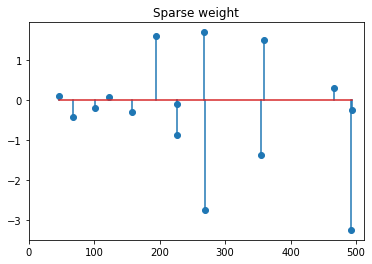

In [14]:
from sklearn import linear_model
from sklearn.datasets import make_sparse_coded_signal

y, X, w = make_sparse_coded_signal(n_samples=1,n_components=512,n_features=100,n_nonzero_coefs=15,random_state=0)
print ('X (train) : ' + str(X.shape[0]) + ' x ' + str(X.shape[1]))
print ('y (test) : ' + str(y.shape[0]) + ' x 1')
print ('w (weight) : ' + str(w.shape[0]) + ' x 1')

idx, = w.nonzero()

plt.figure()
plt.stem(idx, w[idx])
plt.xlim([0,512])
plt.title('Sparse weight')
plt.show()

6.Use the orthogonal matching pursuit algorithm to find the $\hat{w}$ (coefficients) and compare it with the $w$ above (compute $\|w-\hat{w}\|_2^2$). (http://scikit-learn.org/stable/auto_examples/linear_model/plot_omp.html)

You can use scikit-learn OrthogonalMatchingPursuit (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.OrthogonalMatchingPursuit.html). Set $\mbox{n_nonzero_coefs}=20$, $\mbox{fit_intercept}=False$ and default for other parameters. 

C:\Users\Franj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
C:\Users\Franj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


norm squared of (w-w_hat) is:  1.2335581293800247e-30


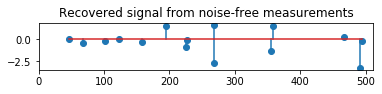

In [15]:
from sklearn.linear_model import OrthogonalMatchingPursuit

#Using code adapted from: http://scikit-learn.org/stable/auto_examples/linear_model/plot_omp.html
omp1 = OrthogonalMatchingPursuit(n_nonzero_coefs=20, fit_intercept = False)
omp1.fit(X, y)
coef = omp1.coef_
idx_r, = coef.nonzero()
plt.subplot(4, 1, 2)
plt.xlim(0, 512)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r])

norm1 = (np.linalg.norm(coef-w))**2
print("norm squared of (w-w_hat) is: ", norm1)

7.Implement the OMP function yourself with following requirements. (Refer to the section 13.5.2 in the notes for the details of the algorithm.)

[Termination conditions]

1)Number of nonzero elements in $w$. 
\begin{equation}
\mbox{number of nonzero elements} = k
\end{equation}
2)Tolerance of the residual.
\begin{equation}
\frac{\|y-\hat{y}\|_2}{\|y\|_2} \leq \mbox{tolerance}
\end{equation}
3)Maximum number of iterations.

In [16]:
# Function outline
from sklearn.linear_model import LinearRegression

def omp(X,y,n_nonzero,tol,max_iter):
    
    NonZero=0
    error=0
    iteration = 0
    r = y 
    S = np.zeros((100,1))    
    wMaster= np.zeros(512)
    
    while iteration <= max_iter: #tolerance and iteration termination conditions 
            
        #increase iteration count
        iteration+=1
        
        #select atom most correlated with residual
        dotProduct = abs(X.T @ r)
        similarAtomPosition = np.argmax(dotProduct)
        similarAtom = X[:,similarAtomPosition]
        similarAtom = np.reshape(similarAtom,(-1,1))
        
        if iteration == 1:
            S[:] = similarAtom
        else:
            S = np.append(S, similarAtom,1)
            
        #solving least squares problem
        w = np.linalg.inv(S.T @ S)@ S.T @ y
        wi= w[iteration-1]
        wMaster[similarAtomPosition] = wi
            
        #update residual
        r = y - S @ w 
        error = np.linalg.norm(r)**2/np.linalg.norm(y)**2
        #print(error)

        #check if we got to the sparsity limit
        NonZero = np.count_nonzero(wMaster)
        
        if NonZero >= n_nonzero: #sparsity termination condition 
            print("Stopped: Reached target sparsity")
            break
            
        if error < tol: #tolerance termination condition 
            print("Stopped: Reached target tolerance")
            break
            
    print("Final Error: ", error, "\n")    
    return wMaster

8.Repeat question 6 using your OMP function. (Set parameters as $\mbox{n_nonzero}=15$,$\mbox{tol}=10^{-30}$,$\mbox{max_iter}=300$)

In [17]:
wOpm = omp(X,y,15,1e-30, 300)
norm2 = (np.linalg.norm(w-wOpm))**2
print("ANSWER: norm squared of (w-w_hat) is: ", norm2)

Stopped: Reached target sparsity
Final Error:  7.391540493375063e-32 

ANSWER: norm squared of (w-w_hat) is:  0.2639261275635498


9.Try changing the tolerance value from $10^{-3}$ to $10^{-30}$ in log scale. 1)Plot the error ($\|w-\hat{w}\|_2^2$) vs. tolerance and 2)number of nonzero elements in $\hat{w}$ vs. tolerance. (Keep $\mbox{n_nonzero}=15$ and $\mbox{max_iter}=300$.)

Stopped: Reached target tolerance
Final Error:  0.0007712308077602594 

Stopped: Reached target sparsity
Final Error:  7.391540493375063e-32 

Stopped: Reached target sparsity
Final Error:  7.391540493375063e-32 

Stopped: Reached target sparsity
Final Error:  7.391540493375063e-32 

Stopped: Reached target sparsity
Final Error:  7.391540493375063e-32 

Stopped: Reached target sparsity
Final Error:  7.391540493375063e-32 

Stopped: Reached target sparsity
Final Error:  7.391540493375063e-32 



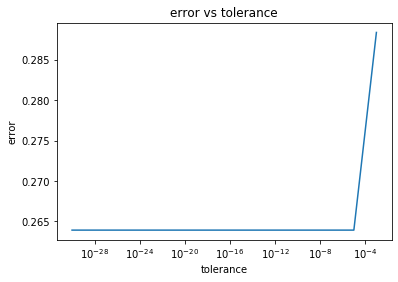

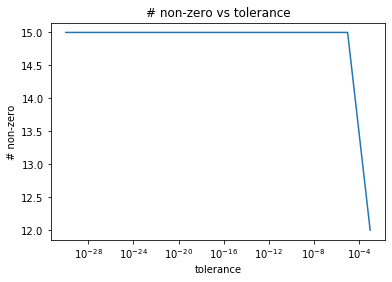

In [18]:
tolList = [1e-3,1e-5,1e-10,1e-15,1e-20,1e-25,1e-30]

normList = []
nonZeroList=[]
testL=[]

for tol in tolList:
    wOpm = omp(X,y,15,tol,300)
    nonZeroList.append(np.count_nonzero(wOpm))
    normList.append(np.linalg.norm(w-wOpm)**2)
    
#plotting error vs tolerance
plt.semilogx(tolList,normList)
plt.title('error vs tolerance')
plt.ylabel("error")
plt.xlabel("tolerance")
plt.show()

#plotting number non-zero vs tolerance
plt.semilogx(tolList,nonZeroList)
plt.title('# non-zero vs tolerance')
plt.ylabel("# non-zero")
plt.xlabel("tolerance")
plt.show()
        